# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/6.SectionRank'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

### The Simulator

simple model without DNF

1. laptime, modeled by average lap time on green laps
2. pitstop, uniform distributed in pit window(10 laps)
3. pitime, modeled by inlap, outlap time


In [4]:
#green laps
alldata = dataset.copy()
carnos = np.sort(list(set(alldata.car_number.values)))
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)

# since the flag changes in the middle of a lap, != 'Y' does not work here
#greendata = rankdata[rankdata['track_status']!='Y']
yellow_laps = rankdata[rankdata['track_status']=='Y'].completed_laps.values
green_laps = set(rankdata.completed_laps.values) - set(yellow_laps)
greendata = rankdata[rankdata['completed_laps'].isin(green_laps)]

# car_number, startpos, norm_lap, in_lap, out_lap
statdata = np.zeros((len(carnos), 8))
for idx, car in enumerate(carnos):
        thiscar = greendata[greendata['car_number']==car]
        
        pit_laps = thiscar[thiscar['lap_status']=='P'].completed_laps.values
        in_lap = thiscar[thiscar['completed_laps'].isin(pit_laps)].last_laptime.values
        out_laps = [x+1 for x in pit_laps]
        out_lap = thiscar[thiscar['completed_laps'].isin(out_laps)].last_laptime.values
        
        normal_laps = set(thiscar.completed_laps.values) - set(pit_laps) -set(out_laps)
        _laps = [x if x-1 in normal_laps else -1 for x in normal_laps]
        _laps=np.array(_laps)
        normal_laps = _laps[_laps>0]
        norm_lap = thiscar[thiscar['completed_laps'].isin(normal_laps)].last_laptime.values
        
        #save statistics
        statdata[idx, 0] = car
        startPos = thiscar[thiscar['completed_laps']==1].start_position.values[0]
        statdata[idx, 1] = int(startPos, 16)
        statdata[idx, 2] = np.mean(norm_lap)
        statdata[idx, 3] = np.std(norm_lap)
        statdata[idx, 4] = np.mean(in_lap)
        statdata[idx, 5] = np.std(in_lap)
        statdata[idx, 6] = np.mean(out_lap)
        statdata[idx, 7] = np.std(out_lap)
        
df = pd.DataFrame({'car_number':statdata[:,0].astype(int),'start_position':statdata[:,1].astype(int),'norm_lap_mean':statdata[:,2],'norm_lap_std':statdata[:,3],
                   'in_lap_mean':statdata[:,4],'in_lap_std':statdata[:,5],'out_lap_mean':statdata[:,6],'out_lap_std':statdata[:,7]})        
df.to_csv(outputprefix + 'simulator.csv')
simdf = df.copy()

In [5]:
df.head(10)

,car_number,in_lap_mean,in_lap_std,norm_lap_mean,norm_lap_std,out_lap_mean,out_lap_std,start_position
0,1,54.339015,8.424845e-01,41.743706,0.766367,66.104833,0.730250,4
1,3,54.281610,7.251726e-01,41.611673,0.676782,66.911113,0.401542,8
2,4,54.295602,3.190570e-01,41.946153,0.770234,68.036082,0.729633,11
3,6,64.027260,8.913270e-01,42.018802,0.778819,55.488440,0.238874,18
4,7,76.500685,5.074079e+00,43.346298,1.081907,58.039793,0.983255,28
5,9,54.458102,1.106836e+00,42.022496,0.701250,66.476525,0.545905,9
6,10,67.298100,1.421085e-14,42.409261,1.136934,55.727200,0.000000,29
7,12,53.857717,1.671692e+00,41.485985,0.776325,65.957933,0.901091,3
8,13,55.341700,7.105427e-15,41.927896,0.640302,67.616600,0.000000,7
9,14,55.449998,1.114515e+00,41.540961,0.629124,66.876700,0.556106,10


In [6]:
# pit window
# the first pit is more reasonable, the pit window should at least to be 7 laps
#
maxpitcnt = max([int(x,16) for x in rankdata.pit_stop_count.values])

for pit in range(1,maxpitcnt):
    pit_laps= np.sort(list(rankdata[(rankdata['pit_stop_count']==('%x'%(pit))) 
                                & (rankdata['lap_status']=='P')].completed_laps.values))
    print('%d:%d, %d'%(pit, min(pit_laps), max(pit_laps)))
    
    

1:29, 36
2:35, 70
3:52, 108
4:60, 141
5:96, 175
6:107, 197
7:120, 196
8:138, 195
9:180, 191


#### Simulator

In [7]:
def run_simulator(rankdata, simdf, savemodel='', baselap=0, basemodel=None):
    """
    input: simdf, rankdata
    baselap;  fix output before the startlap 
    basemode;  data[] of a previous run/simulation result
    
    simulator output the same data format as rankdata(C_xxx)
        #rank, car_number, completed_laps,elapsed_time,last_laptime
        #lap_status,track_status, pit_stop_count, last_pitted_lap
    """
    
    #init
    #random.seed(1234)
    random.seed()

    maxlaps = max(set(rankdata.completed_laps.values))
    cols=['rank', 'car_number', 'completed_laps','elapsed_time','last_laptime',
          'lap_status','track_status', 'pit_stop_count', 'last_pitted_lap']
    colid={key:idx for idx, key in enumerate(cols)}

    # fixed pit strategy
    # max laps = 38
    # pit window = 8
    # uniform distribution in [last_pit+38-8, last_pit+38]
    pit_maxlaps = 38
    pit_window = 8
    carnos = np.sort(list(set(simdf.car_number.values)))
    #carnos = simdf.car_number.values
    carid = {key:idx for idx, key in enumerate(carnos)}

    data = np.zeros((len(carnos)*maxlaps, len(cols)))
    #print('maxlaps=%d, data shape=%s'%(maxlaps, data.shape))    
    
    # fixed pit strategy
    # max laps = 38
    # pit window = 8
    # uniform distribution in [last_pit+38-8, last_pit+38]
    for car in carnos:
        curlap = 0
        pit_cnt = 0
        
        #get data from basemodel
        if baselap > 0:
            thiscar_model = basemodel[carid[car] * maxlaps:(carid[car]+1) * maxlaps,:]
            thiscar_pitlaps = np.argwhere(thiscar_model[:,colid['lap_status']]==1) 
            thiscar_pitlaps_idx = 0
            #debug
            #if car == 88:
            #    print('car 88:', thiscar_pitlaps)
        
        while curlap < maxlaps:
            #set the next pit lap
            #uniform in [curlap + ]
            right = curlap + pit_maxlaps
            if right > maxlaps:
                # no need to pitstop
                break
            left = curlap + pit_maxlaps - pit_window
            
            #dynamic 
            if baselap > 0:
                pit_lap = thiscar_pitlaps[thiscar_pitlaps_idx] 
                if pit_lap >= baselap:
                    #wait until pit_lap >= baselap
                    pit_lap = int(random.uniform(left, right))    
                    while pit_lap < baselap:
                        pit_lap = int(random.uniform(left, right))
                else:
                    #use the basemodel
                    thiscar_pitlaps_idx += 1
            else:
                pit_lap = int(random.uniform(left, right))
            
            
            #set it
            data[carid[car] * maxlaps + pit_lap, colid['lap_status']] = 1
            data[carid[car] * maxlaps + pit_lap, colid['pit_stop_count']] = pit_cnt
            data[carid[car] * maxlaps + pit_lap, colid['last_pitted_lap']] = pit_lap + 1

            pit_cnt += 1
            curlap = pit_lap
            
    # simulate the lap time
    # startPenalty = startPosition * 0.11(s)

    for car in carnos:
        last_ispit = 0
        param = simdf[simdf['car_number']==car]
        elapsed_time = param.start_position * 0.11
        
        #get data from basemodel
        if baselap > 0:
            thiscar_model = basemodel[carid[car] * maxlaps:(carid[car]+1) * maxlaps,:]        
        
        for lap in range(maxlaps):
            #use out_lap
            cur_ispit = data[carid[car] * maxlaps + lap, colid['lap_status']]
            if baselap > 0 and lap <= baselap:
                laptime = thiscar_model[lap,colid['last_laptime']]
            else:
                if last_ispit:
                    laptime = random.gauss(param['out_lap_mean'],param['out_lap_std'])
                elif cur_ispit:
                    #use in_lap
                    laptime = random.gauss(param['in_lap_mean'],param['in_lap_std'])
                else:
                    #use norm_lap
                    laptime = random.gauss(param['norm_lap_mean'],param['norm_lap_std'])

            data[carid[car] * maxlaps + lap, colid['last_laptime']] = laptime
            if baselap > 0 and lap <= baselap:
                elapsed_time = thiscar_model[lap,colid['elapsed_time']]
            else:
                elapsed_time += laptime
                
            data[carid[car] * maxlaps + lap, colid['elapsed_time']] = elapsed_time

            data[carid[car] * maxlaps + lap, colid['car_number']] = car
            #start from lap 1
            data[carid[car] * maxlaps + lap, colid['completed_laps']] = lap + 1

            #update and goto next lap
            last_ispit = cur_ispit

    # update the rank
    # carnumber = len(carnos)
    for lap in range(maxlaps):
        elapsed_time = [data[carid[car] * maxlaps + lap, colid['elapsed_time']] for car in carnos]
        indice = np.argsort(elapsed_time)
        rank = np.arange(len(carnos))
        out = np.arange(len(carnos))
        out[indice] = rank + 1
        for car in carnos:
            data[carid[car] * maxlaps + lap, colid['rank']] = int(out[carid[car]])

    #save data
    #rank, car_number, completed_laps,elapsed_time,last_laptime
    #lap_status,track_status, pit_stop_count, last_pitted_lap
    df = pd.DataFrame({'rank': data[:, 0].astype(int), 'car_number': data[:, 1].astype(int),
                       'completed_laps': data[:, 2].astype(int),
                       'elapsed_time': data[:, 3], 'last_laptime': data[:, 4], 
                       'lap_status': [ 'P' if x==1 else 'T' for x in data[:, 5]],
                       'track_status': [ 'G' for x in data[:, 6]],
                       'pit_stop_count': data[:, 7], 'last_pitted_lap': data[:, 8]})
    if savemodel:
        df.to_csv(savemodel)
    
    return df, data

In [8]:
df0, data0 = run_simulator(rankdata, simdf)
df1, data1 = run_simulator(rankdata, simdf, '', 100, data0)

In [9]:
np.mean(data0[:100,:]==data1[:100,:])

1.0

In [10]:
np.mean(data0[100:,:]==data1[100:,:])

0.8383931623931624

In [11]:
df0[(df0['car_number']==88) & (df0['lap_status']=='P')]

,car_number,completed_laps,elapsed_time,lap_status,last_laptime,last_pitted_lap,pit_stop_count,rank,track_status
6231,88,32,1370.843156,P,68.624514,32.0,0.0,28,G
6263,88,64,2756.037393,P,64.846933,64.0,1.0,26,G
6298,88,99,4259.117143,P,66.060212,99.0,2.0,20,G
6334,88,135,5817.348909,P,66.204121,135.0,3.0,18,G
6366,88,167,7200.412543,P,66.551938,167.0,4.0,18,G


In [12]:
df0[df0['completed_laps']==100]

,car_number,completed_laps,elapsed_time,lap_status,last_laptime,last_pitted_lap,pit_stop_count,rank,track_status
99,1,100,4244.463828,T,42.185982,0.0,0.0,6,G
299,3,100,4260.723993,T,67.384361,0.0,0.0,7,G
499,4,100,4281.465969,T,41.526644,0.0,0.0,16,G
699,6,100,4308.769828,T,55.613627,0.0,0.0,19,G
899,7,100,4481.546738,T,41.431873,0.0,0.0,33,G
1099,9,100,4277.404218,T,41.856190,0.0,0.0,12,G
1299,10,100,4351.255416,P,67.298100,100.0,2.0,31,G
1499,12,100,4220.949946,P,52.878132,100.0,2.0,1,G
1699,13,100,4320.740110,T,41.470961,0.0,0.0,25,G
1899,14,100,4227.893066,T,42.146159,0.0,0.0,2,G


In [13]:
df1[df1['completed_laps']==100]

,car_number,completed_laps,elapsed_time,lap_status,last_laptime,last_pitted_lap,pit_stop_count,rank,track_status
99,1,100,4244.463828,T,42.185982,0.0,0.0,6,G
299,3,100,4260.723993,T,67.384361,0.0,0.0,7,G
499,4,100,4281.465969,T,41.526644,0.0,0.0,16,G
699,6,100,4308.769828,T,55.613627,0.0,0.0,19,G
899,7,100,4481.546738,T,41.431873,0.0,0.0,33,G
1099,9,100,4277.404218,T,41.856190,0.0,0.0,12,G
1299,10,100,4351.255416,P,67.298100,100.0,2.0,31,G
1499,12,100,4220.949946,P,52.878132,100.0,2.0,1,G
1699,13,100,4320.740110,T,41.470961,0.0,0.0,25,G
1899,14,100,4227.893066,T,42.146159,0.0,0.0,2,G


### run simulation

In [14]:
# total runs, model runs = 80%
runs = 120
modelruns = 100

maxlaps = max(set(rankdata.completed_laps.values))
carnos = np.sort(list(set(simdf.car_number.values)))
carid = {key:idx for idx, key in enumerate(carnos)}

#laps = [100,200]
laps = range(1,201)
#contigency matrix
#<lap, carno, rank> -> count
cmat = np.zeros((len(laps), len(carnos), len(carnos)))
#simulation result 
simretdf = []
#<run, lap, carno> -> rank
simdata = np.zeros((runs, len(laps), len(carnos)))


dfseed,dataseed = run_simulator(rankdata, simdf)
baselap = 50

# run simulator
for run in range(runs):
    #fix the laps before baselap
    df,_ = run_simulator(rankdata, simdf, '', baselap, dataseed)
    simretdf.append(df)
    
    for idx, lap in enumerate(laps):
        data = df[df['completed_laps']==lap][['car_number','rank']].to_numpy()
        for pt in data:
            simdata[run, idx, carid[pt[0]]] = pt[1]
    
    
# build statistics model
for run in range(modelruns):    
    df = simretdf[run]
    
    #save rank@lap100 and rank@lap200
    for idx, lap in enumerate(laps):
        data = df[df['completed_laps']==lap][['car_number','rank']].to_numpy()
        for pt in data:
            cmat[idx, carid[pt[0]], pt[1]-1] += 1
    
print('simulation finished!')

#get the test data
simtestdata = simdata[modelruns-runs:,:,:]
print('sim cmat:', cmat.shape)
print('sim testdata:', simtestdata.shape)

simulation finished!
('sim cmat:', (200, 33, 33))
('sim testdata:', (20, 200, 33))


In [15]:
#save the simulation result
retfile = outputprefix + 'simulator-run%d.dat'%runs
cmatsave = cmat.reshape((-1, len(carnos)*len(carnos)))
np.savetxt(retfile, cmatsave)

retfile = outputprefix + 'simulator-data%d.dat'%runs
simdatasave = simdata.reshape((-1, len(laps)*len(carnos)))
np.savetxt(retfile, simdatasave)


### check the result

In [16]:
#check the result
laps = [1,15,32,50,60, 110,150,200]
#check rank 1@lap100, @lap200
for lap in laps:
    print('rank1@lap',lap, ':', cmat[lap-1,:,0])
    
#print('rank1@lap200:',cmat[1,:,0])

('rank1@lap', 1, ':', array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))
('rank1@lap', 15, ':', array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))
('rank1@lap', 32, ':', array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))
('rank1@lap', 50, ':', array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))
('rank1@lap', 60, ':', ar

#### check the result of will power

In [17]:
cmat[:,7,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  13.,  19.,  18.,
        22.,  23.,  24.,  25.,  21.,  27.,  26.,  25.,  29.,  31.,  41.,
        51.,  50.,  58.,  59.,  63.,  66.,  68.,  65.,  58.,  52.,  47.,
        46.,  47.,  45.,  45.,  49.,  48.,  51.,  47.,  48.,  49.,  44.,
        46.,  49.,  51.,  51.,  52.,  55.,  54.,  56.,  56.,  63.,  66.,
        72.,  69.,  62.,  66.,  66.,  63.,  61.,  61.,  67.,  67.,  71.,
        68.,  69.,  68.,  67.,  68.,  68.,  64.,  68.,  65.,  64.,  64.,
        67.,  67.,  68.,  68.,  68.,  69.,  71.,  69.,  67.,  67.,  68.,
        71.,  73.,  78.,  74.,  68.,  76.,  76.,  79.,  73.,  71.,  71.,
        75.,  76.,  73.,  71.,  71.,  71.,  72.,  7

In [18]:
leader = rankdata[rankdata['rank']==1]
willpower_in_lead = leader[leader['car_number']==12].completed_laps.values
willpower_pred_lead = cmat[:,7,0]
willpower_in_lead

array([ 92,  93,  94, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 196, 197, 198, 199, 200])

In [19]:
willpower_in_lead.astype(int)-1

array([ 91,  92,  93, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 195, 196, 197, 198, 199])

In [20]:
willpower_pred_lead[willpower_in_lead.astype(int)-1]

array([51., 52., 55., 67., 67., 71., 68., 69., 68., 67., 68., 68., 64.,
       68., 65., 64., 64., 67., 67., 68., 68., 68., 69., 71., 73., 71.,
       71., 75., 76., 73., 71., 71., 71., 72., 70., 72., 74., 72., 74.,
       74., 75., 75., 74., 78., 75., 78., 71., 72., 75., 73., 74., 74.,
       73., 75., 88., 86., 85., 86., 86.])

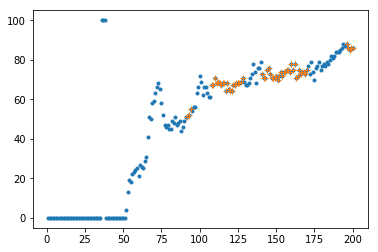

In [21]:
laps = range(1,201)
plt.plot(laps, willpower_pred_lead,'.')
plt.plot(willpower_in_lead, willpower_pred_lead[willpower_in_lead.astype(int)-1],'+')
plt.show()

#### performance of the simulator prediction

In [22]:
#model preidction on first 80 simulation results 
laps = range(1,201)
simulator_pred = []
for lap in laps:
    simulator_pred.append(np.argmax(cmat[lap-1,:,0]))
    
simulator_pred = np.array(simulator_pred)
simulator_pred

array([14, 14, 14, 14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  7,  7,  7,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])

In [23]:
#
#  over the groundtruth
#
# test on the latest 20
testruns = runs - modelruns
testret = np.zeros((testruns, len(simulator_pred)))
for run in range(modelruns, runs):
    df = simretdf[run]
    leader = df[df['rank']==1]
    leader = leader.rename_axis('MyIdx').sort_values(by=['completed_laps','MyIdx'], ascending=True)
    ground_truth = []
    for car in leader.car_number.values:
        ground_truth.append(carid[car] )
    ground_truth = np.array(ground_truth)
    
    idx = ((simulator_pred - ground_truth) == 0)
    testret[run-modelruns,:] = idx
#show result    
print('mean rank1 accuracy:', np.mean(testret[:,baselap:]), np.mean(testret[:,baselap:], axis=1))

#check rank1@lap10, fixed prediction
laps = [1,15,32,50,60,110, 150,200]
for lap in laps:
    print('mean rank1@lap',lap, 'accuracy:', np.mean(testret[:,lap-1]))
#print('mean rank1@lap10 accuracy:', np.mean(testret[:,9]))
#print('mean rank1@lap10 accuracy:', np.mean(testret[:,9]))


('mean rank1 accuracy:', 0.653, array([0.92      , 0.66666667, 0.26      , 0.08666667, 0.76666667,
       0.54      , 0.43333333, 0.94      , 0.95333333, 0.42666667,
       0.78      , 0.91333333, 0.70666667, 0.93333333, 0.57333333,
       0.7       , 0.38666667, 0.95333333, 0.58666667, 0.53333333]))
('mean rank1@lap', 1, 'accuracy:', 1.0)
('mean rank1@lap', 15, 'accuracy:', 1.0)
('mean rank1@lap', 32, 'accuracy:', 1.0)
('mean rank1@lap', 50, 'accuracy:', 1.0)
('mean rank1@lap', 60, 'accuracy:', 0.5)
('mean rank1@lap', 110, 'accuracy:', 0.65)
('mean rank1@lap', 150, 'accuracy:', 0.7)
('mean rank1@lap', 200, 'accuracy:', 0.7)


In [29]:
    run = modelruns + 2
    df = simretdf[run]
    leader = df[df['rank']==1]
    
    leader = leader.rename_axis('MyIdx').sort_values(by=['completed_laps','MyIdx'], ascending=True)
    
    ground_truth = []
    for car in leader.car_number.values:
        ground_truth.append(carid[car] )
    ground_truth = np.array(ground_truth)
    ground_truth

array([14, 14, 14, 14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  7,  7,  7,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  7,  7,  7,  7, 14, 14, 14, 14, 14, 14, 14, 14, 14,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  7,  7,  7,  7,  9,  9,  9,  9,  9, 14, 14, 14, 14,  9,
       14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  7,  7,  7,  7,  7,  7, 14,  9, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9])

In [25]:
leader

,car_number,completed_laps,elapsed_time,lap_status,last_laptime,last_pitted_lap,pit_stop_count,rank,track_status
MyIdx,,,,,,,,,
2800,20,1,41.387500,T,41.277500,0.0,0.0,1,G
2801,20,2,82.824671,T,41.437171,0.0,0.0,1,G
2802,20,3,123.375633,T,40.550962,0.0,0.0,1,G
2803,20,4,165.085399,T,41.709766,0.0,0.0,1,G
2804,20,5,206.835857,T,41.750458,0.0,0.0,1,G
2805,20,6,247.201862,T,40.366004,0.0,0.0,1,G
2806,20,7,288.052920,T,40.851059,0.0,0.0,1,G
2807,20,8,330.623178,T,42.570258,0.0,0.0,1,G
2808,20,9,372.480097,T,41.856918,0.0,0.0,1,G


In [26]:
#
#  over the realrace truth
#
ground_truth = []
leader = rankdata[rankdata['rank']==1]
leader = leader.rename_axis('MyIdx').sort_values(by=['completed_laps','MyIdx'], ascending=True)
for car in leader.car_number.values:
    ground_truth.append(carid[car] )
len(ground_truth)
ground_truth = np.array(ground_truth)
ground_truth

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  0, 15, 15,
       15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,  9,  9, 14, 14, 14,
       14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 14, 14,  7,  7,  7, 29, 12, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 13, 13,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 22, 12, 12, 12,  0,  0, 10,
       10, 10, 23, 23, 23,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7, 14, 14, 21, 16, 23, 29, 29,  3,  3, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 19, 19, 19,  7,  7,  7,  7,  7])

In [27]:
idx = ((simulator_pred - ground_truth[1:]) == 0)
print(np.mean(idx), np.mean(idx[100:]),np.mean(idx[:50]),np.mean(idx[:100]),np.mean(idx[:150]))

(0.35, 0.56, 0.18, 0.14, 0.3)


In [28]:
# very low accuracy
idx = (simulator_pred - ground_truth[1:]) == 0
simulator_pred[idx]


array([14, 14, 14, 14, 14, 14, 14, 14, 14,  9,  9,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7])

### conclusion

even such a simple simulator demonstrates the uncertainty of the long term rank distribution.